# Pandas Datetime Capabilities and Visualizations

Pandas' datetime objects makes it possible to accomplish complex datetime operations in just a few lines of code.

In [2]:
# importing the libraries for data processing
import numpy as np 
import pandas as pd 

#matplotlib for visualizations
import matplotlib.pyplot as plt


### 1. Data Preparation

In [31]:
# read and process the charts dataset
charts_df = pd.read_csv('data/spotify_daily_charts.csv')
charts_df = pd.concat([charts_df,pd.read_csv('data/spotify_daily_charts_.csv')])

#transform date column into a datetime column
charts_df['date'] = pd.to_datetime(charts_df['date'])
charts_df = charts_df.set_index('date')
charts_df.tail()

,position,track_id,track_name,artist,streams
date,,,,,
2022-01-29,196,20on25jryn53hWghthWWW3,Do It To It,ACRAZE,31663
2022-01-29,197,1aEsTgCsv8nOjEgyEoRCpS,this is how you fall in love,Jeremy Zucker,31636
2022-01-29,198,3nsfB1vus2qaloUdcBZvDu,All Too Well (Taylor's Version),Taylor Swift,31608
2022-01-29,199,5FVbvttjEvQ8r2BgUcJgNg,Life Goes On,BTS,31557
2022-01-29,200,6f7BE3VcZScJx6n3wsf5Z3,I Like U,NIKI,31490


### 2. Static time series plot in matplotlib

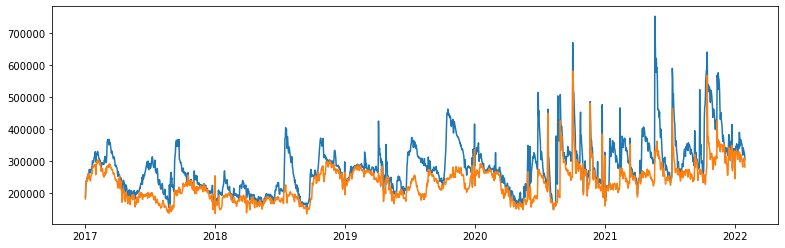

In [32]:
#top 2
fig = plt.figure(figsize=(13,4))
ax = fig.add_subplot(111)

data1 = charts_df[charts_df['position']==1]
plt.plot(data1['streams'])

data2 = charts_df[charts_df['position']==2]
plt.plot(data2['streams'])

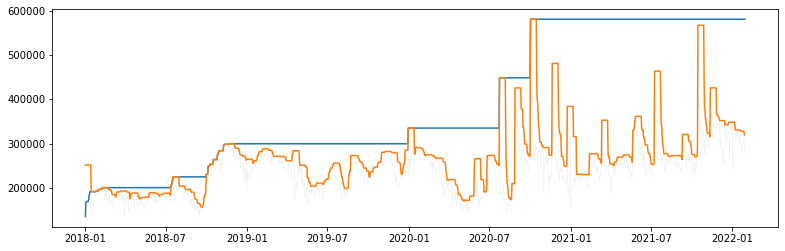

In [33]:
#top 2
fig = plt.figure(figsize=(13,4))
ax = fig.add_subplot(111)
data = charts_df.copy()

data2 = data[data['position']==2]
streams_goal = data2['streams']['2018-01-01':]+1
plt.plot(streams_goal, lw=0.5, color= '0.9', alpha=0.7)

data2 = data[data['position']==2]
streams_goal = data2['streams']['2018-01-01':].cummax()+1
plt.plot(streams_goal,'C0')

data3 = data[data['position']==2]#.cummax()
streams_goal = data2['streams'].rolling(14).max()['2018-01-01':]+1
plt.plot(streams_goal,'C1')

#data3 = data[data['position']==2]#.cummax()
#streams_goal = data2['streams'].rolling(30).max()['2018-01-01':]+1
#plt.plot(streams_goal,'C3')

Insights
- streams are concrete measure of audience
- like currency position changes value
- inflation correction?

### 3. Interactive time series plot in Bokeh


In [7]:
# Standard imports 
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, save

from bokeh.models.tools import HoverTool
from bokeh.models import Legend
from bokeh.models import ColumnDataSource, Range1d
output_notebook()

Loading BokehJS ...

#### Top 1 vs top 2

In [17]:
#Simple time series plot with selectable legend and hover output
p = figure(x_axis_type="datetime", title="Spotify Daily Charts", plot_height=350, plot_width=800)

#reformat data to suit ColumnDataSource
#loop over data, filter and plot glyph-line
positions = [1,2]
df = charts_df.copy()
colors = ['blue','red']
for n,pos in enumerate(positions):
    data_df = df[(df['position']==pos)]
    #declare as column data source for hover
    source = ColumnDataSource(data = {'date': data_df.index.values,
                                      'artist': data_df['artist'].values,
                                      'track_name': data_df['track_name'].values,
                                      'streams': data_df['streams'].values,})
    #plot glyph-line
    #add .flatten() to y-values to deal with rolling window value nesting
    p.line(x='date', y='streams', color=colors[n], source=source, legend_label='Top %d' % pos)
    #add hover tool
    p.add_tools(HoverTool(
        tooltips=[
                ( 'Date',   '@date{%F}'),
                ( 'Artist', '@artist'      ),
                ( 'Track name', '@track_name'      ),
                ( 'Streams',  '@streams' ), # use @{ } for field names with spaces

            ],
        formatters={
            '@date' : 'datetime',
        }
    ))

#plot formatting parameters
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=0.5
p.xaxis.axis_label = 'date'
p.yaxis.axis_label = 'streams'
p.yaxis.formatter.use_scientific = False

p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)

>Q: Compare the contribution of the top 1-50 tracks vs top 50-200 tracks in the yearly streams of Spotify

In [ ]:
#add is_in_top_50 column in df
df = charts_df.copy()
df['is_in_top50']=df['position']<=50
df = df.set_index('date')
df.head()

In [ ]:
#get total yearly streams
yr_df = df.groupby('is_in_top50')[['streams']].resample('Y').sum().reset_index()
yr_df = yr_df.set_index('date')
yr_df

In [ ]:
#initialize plot
p = figure(title="Spotify Yearly Streams for Charting Tracks",plot_width=500, plot_height=300)
#plot glyphs - vertical bar
#top 1-50
data = yr_df[yr_df['is_in_top50']==True]
b1 = p.vbar(x=data.index.year.values-0.15,\
       top=data['streams'].values/1000000000,
       width=0.2, bottom=0, color="crimson",  muted_alpha=0.2)
#top 50-200
data = yr_df[yr_df['is_in_top50']==True]
b2 = p.vbar(x=data.index.year.values+0.15,\
       top=data['streams'].values/1000000000,
       width=0.2, bottom=0, color="dodgerblue", muted_alpha=0.2)
#set plot parameters
#axis
p.xaxis.axis_label = 'date'
p.yaxis.axis_label = 'Streams (in billions)'
#legend
p.legend.label_text_font_size = '8pt'
p.legend.click_policy="hide"

show(p)

In [ ]:
#initialize plot
p = figure(title="Spotify Yearly Streams for Charting Tracks",plot_width=500, plot_height=300)
data = yr_df

legend_labels = ['Top50','Top51-200']
legend_it = []
#plot glyphs - vertical bar

#top 1-50
data = yr_df[yr_df['is_in_top50']==True]
b1 = p.vbar(x=data.index.year.values-0.15,\
       top=data['streams'].values/1000000000,
       width=0.2, bottom=0, color="crimson",  muted_alpha=0.2)
#top 50-200
data = yr_df[yr_df['is_in_top50']==True]
b2 = p.vbar(x=data.index.year.values+0.15,\
       top=data['streams'].values/1000000000,
       width=0.2, bottom=0, color="dodgerblue", muted_alpha=0.2)

#set plot parameters
#legend, out of plot area
legend_it = list(zip(legend_labels,[[b1],[b2]]))
legend = Legend(items=legend_it)
p.add_layout(legend, 'right')
p.legend.click_policy="mute"

#axis
p.xaxis.axis_label = 'date'
p.yaxis.axis_label = 'Streams (in billions)'

show(p)

>Q: What insights can you infer from the chart above?

In [ ]:
#save most recent plot
output_file('figs/position_plot.html', mode='inline')
save(p)

## Try it yourself!

1. Among those included in the Spotify charts, pick 1 artist you like to analyze. 

   a. Plot the streams and positions of their top 5 streamed songs.
   
   b. Compare these charts with streams and positions of what you feel to be a possible collaborator/competitor/related artist. 

   What insights can you draw from the data?